# Loading libraries, data and a model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
%matplotlib inline
import MCMC as MCMC_toolkit
import emcee
from tqdm import tqdm
import marginalise_likelihood as margLIN
from getdist import MCSamples, plots

settings = {
'ignore_rows':0.5,
'fine_bins_2D':1000, 
'smooth_scale_1D':0.5,
'smooth_scale_2D':0.5
}

In [2]:
WALKERS_PER_PARAMETER = 7

#Info for convergence - smoothAMP
gelman_rubins = {}
gelman_rubins['N'] = 4 #Number of parallel chains
gelman_rubins['epsilon'] = 0.01 #Threshold for convergence
gelman_rubins['min_length'] = 1000 #Minimum length. All convergence tests are done after this 
gelman_rubins['convergence_steps'] = 1000 #Convergence condition is computed every this step values
gelman_rubins['initial'] = 'uniform_prior' #Method to set the walkers initial position

# Ideas and definitions

The module marginalise_likelihood performs an analytical marginalization over linear parameters appearing in the Likelihood. If the Likelihood is linear in some parameters, it means that the theoretical model can be split in the following way:

$$
P^{(\rm t)} = P^{\rm t}_{\rm const}(\{c_i\}) + \sum_i \theta_i P^{\rm t}_{lin, i}(\{c_i\}) \;,
$$

where $C$ is the covariance matrix and $\{\theta_i\}$, $\{c_i\}$ are the linear and non-linear parameters contributing to the model, respectively. By plugging this into the expression for the Likelihood:

$$
\mathcal{L}(\mathrm{data}|\{\theta_i\ , c_i\}) = \mathrm{Exp} \left[ -\frac{1}{2} \left(P^{\mathrm d} - P^{\mathrm t}\right) \cdot C^{-1}\left(P^{\mathrm d} - P^{\mathrm t}\right) ^{T}\right]\;,
$$

where $P^{\mathrm d}$ is the data array. After some algebra (see notes), one can rewrite the above expression as:

$$
\mathcal{L}(\mathrm{data}|\{\theta_i\ , c_i\}) = \mathrm{Exp} \left[-\frac{1}{2}\sum_{i,j} \theta_i \mathbf{\mathcal{A} }_{ij} \theta_j + \sum_i \theta_i \mathbf{\mathcal{B}}_i + \mathbf{\mathcal{C}}\right]\;,
$$
where we introduced $\star$ to represent the quadratic form $A\star B = A\cdot C^{-1} B^{T}$. The matrices above are defined as:
$$
\begin{align}
\mathbf{\mathcal{A}}_{ij} &=& P^{\rm t}_{lin, i}\star P^{\rm t}_{lin, j}\;,\\
\mathbf{\mathcal{B}}_{i}  &=& -\frac{1}{2} \left(P^{\rm t}_{\mathrm{const}}\star P^{\rm t}_{\mathrm{lin},i} - P^{\rm d}\star P^{\rm t}_{\mathrm{lin},i} - P^{\rm t}_{\mathrm{lin},i}\star P^{\rm d} + P^{\rm t}_{\mathrm{lin},i}\star P^{\rm t}_{\mathrm{const}} \right)\;,\\
\mathbf{\mathcal{C}} &=& -\frac{1}{2} \left( P^{\rm d}\star P^{\rm d} - P^{\rm d}\star P^{\rm t}_{\mathrm{const}} - P^{\rm t}_{\mathrm{const}}\star P^{\rm d} + P^{\rm t}_{\mathrm{const}}\star P^{\rm t}_{\mathrm{const}} \right)\;.
\end{align}
$$
The integral over $\theta_i$  is now straightforward and will produce the marginalised Likelihood, $\mathcal{L}(\mathrm{data}|\{c_i\})$. The result is:
$$
\mathcal{L}(\mathrm{data}|\{c_i\}) = \int d\vec{\theta}\mathrm{Exp} \left[-\frac{1}{2}\sum_{i,j} \theta_i \mathbf{\mathcal{A} }_{ij} \theta_j + \sum_i \theta_i \mathbf{\mathcal{B}}_i + \mathbf{\mathcal{C}}\right] = (2\pi)^{n} \mathrm{Exp}\left[\frac{1}{2} \mathbf{\mathcal{B}}\cdot\mathbf{\mathcal{A}}^{-1}\cdot\mathbf{\mathcal{B}} + \mathbf{\mathcal{C}} - \frac{1}{2}\log\det \mathbf{\mathcal{A}} \right]\;.
$$
Using the Likelihood above it is possible to marginalize over fewer parameters, which can improve the sampling speed and convergence. In what follows, I will show how it can be used in practice.


# Example 1 - Galaxy Power Spectrum

A common template used in Cosmology to model the smooth part of the galaxy power spectrum is:

$$
P_g^{\mathrm{nw}}(k)=B^2 P^{\mathrm{nw}}(k) \frac{1}{\left(1+k^2 \Sigma_s^2 / 2\right)^2}+\frac{a_1}{k^3}+\frac{a_2}{k^2}+\frac{a_3}{k}+a_4+a_5 k^2
$$

The $P^{\rm nw}(k)$ is a pre-calculated curve, which I will load. Without marginalizing the parameters, we would need to sample 
$$
\left\{B, \Sigma_s, a_1, a_2, a_3, a_4, a_5\right\}\;.
$$
However, since the $a_i's$ appears linearly in the model, they can be marginalized over. What we will do is generate some fake data and try to recover $B$ and $\Sigma_s$ in two ways. The first way will be using the linear marginalization code, in which we remove the $a_i's$ terms from the sampling. In the second case, we try to sample the whole set of parameters.

## Generating data and implementing the model

In [3]:
def SmoothAmplitude(params, args, h = 0.676, kh_norm = 0.005, mean_P0 = 13622):
    
    #Unpack the parameters
    B, sigma_s, a0 ,a1 , a2, a3, a4 = params
    
    #Load external info
    kh, ps_smooth_func = args
    
    #Values to normalize the broadband parameters
    k_norm = kh_norm/h # [h/Mpc]

    #Non-wiggle linear
    P_nw_linear = ps_smooth_func(kh)

    #Compute the velocity damping term
    F_fog = 1.0/(1.0 + 0.5*kh**2*sigma_s**2)**2
    
    #Theory - Broadband
    invk = k_norm/kh
    theory_broadband = a0*invk**3 + a1*invk**2 + a2*invk + a3 + a4*(kh/k_norm)**2

    #Compute the full non-wiggle part
    P_nw = B**2*P_nw_linear*F_fog + theory_broadband*mean_P0**2

    return P_nw

In [4]:
#Loading pre-calculated data
power_spec = np.loadtxt("BOSS_z1_new.txt")
kh, ps_smooth_points, O_lin_points, ps_lin_points = power_spec[:,0], power_spec[:,1],\
power_spec[:,2],power_spec[:,3]

ps_smooth_func = InterpolatedUnivariateSpline(kh, ps_smooth_points, ext = 3)

#Generating some fake data
dk = 0.005
k_array = np.arange(0.005,0.2,dk)
B = 5
sigma_s = 10
a0        = 1e-7
a1        = 1e-7
a2        = 1e-4
a3        = 1e-4
a4        = 1e-9
fake_data = SmoothAmplitude([B, sigma_s, a0 ,a1 , a2, a3, a4], args = (k_array, ps_smooth_func))

#Generating a Gaussian covariance matrix
L = 2000 # Mpc/h
vf = (2.0*np.pi)**3/L**3
Nk = 0.5*(4.0*np.pi*k_array**2*dk/vf)
nbar = 1e-4

N_A = 1 + 1/(nbar*fake_data)
COV_diag = 1/Nk*2*fake_data**2*N_A**2
fake_COV = np.zeros((len(k_array), len(k_array)))
np.fill_diagonal(fake_COV,COV_diag)

Text(0, 0.5, '$k\\times P(k)$ $\\mathrm{[Mpc/h]}^2$')

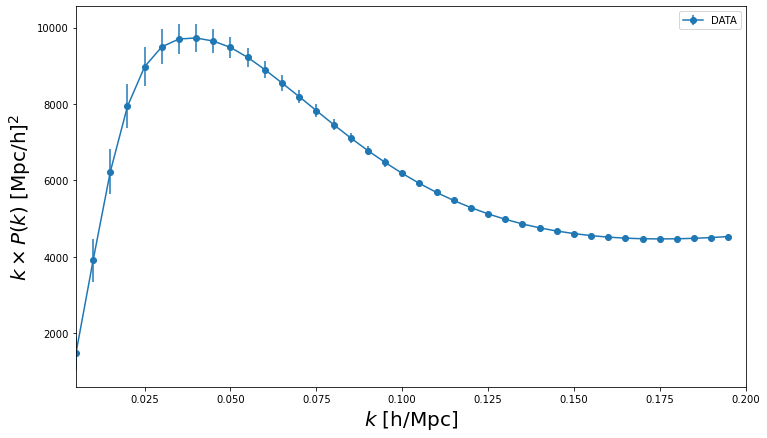

In [5]:
plt.figure(figsize = (12,7))
plt.errorbar(k_array, k_array*fake_data, yerr = k_array*np.diag(fake_COV)**0.5, label = "DATA", marker = "o")
plt.xlim((0.005,0.2))
plt.legend()
plt.xlabel(r"$k$ [h/Mpc]",size = 20)
plt.ylabel(r"$k\times P(k)$ $\mathrm{[Mpc/h]}^2$",size = 20)

# Sampling the marginalised posterior

Here is how you can define the marginalised posterior explicitly:

$$
\mathcal{L}(\mathrm{data}|\{c_i\}) = \int d\vec{\theta}\mathrm{Exp} \left[-\frac{1}{2}\sum_{i,j} \theta_i \mathbf{\mathcal{A} }_{ij} \theta_j + \sum_i \theta_i \mathbf{\mathcal{B}}_i + \mathbf{\mathcal{C}}\right] = (2\pi)^{n} \mathrm{Exp}\left[\frac{1}{2} \mathbf{\mathcal{B}}\cdot\mathbf{\mathcal{A}}^{-1}\cdot\mathbf{\mathcal{B}} - \frac{1}{2}\log\det \mathbf{\mathcal{A}}  + \mathbf{\mathcal{C}} \right]\;.
$$

In [6]:
def loglikelihood_marginalised(theta, theta_marginalised,flat_prior, linear_indices, 
                               model, data, inv_cov, theory_args = None):
    """Compute the marginalised likelihood

    Args:
        theta (list): A list with the remaining free parameters in the model. These paramters change
        on every step of the MCMC analysis.
        
        theta_marginalised (list): Some exemplary values for the linear parameters you marginalised
        . They are used to get the constant and linear part on every step. These parameters are fi-
        xed, they do not vary on every step of the MCMC analysis.
        
        flat_prior (function): The flat prior for the model.
        
        linear_indices (list): A list with the indices where the linear parameters you are margina-
        lising occur in the total param array
       
        model (function): The theoretical model being used. It must be implemented such that its in-
        puts are of the form: model(params, args(optional)).
        
        data (np.array): The data vector.
        
        inv_cov (np.array): The inverse of the covariance matrix
        
        theory_args (_type_, optional): _description_. Defaults to None.

    Returns:
        float: The output for the marginalised log likelihood
    """
     #Apply a flat prior to some parameters
    if not(flat_prior(theta)):
        return(-np.inf)
    
    params = np.hstack((theta, theta_marginalised))
    
    #Get linear terms
    linear_operators_list = margLIN.get_lin_operator_list(model, params, linear_indices, args = theory_args)
    
    #Get the constant part
    theory_const = margLIN.get_const_part(model, params, linear_indices, args = theory_args)
    
    #Compute the matrices
    A_ij = margLIN.compute_Aij(linear_operators_list, inv_cov)
    
    B_i  = margLIN.compute_Bi(linear_operators_list, theory_const, data, inv_cov)
    
    C    = margLIN.compute_C(theory_const, data, inv_cov)
    
    #Get the inverse of A
    invAij = np.linalg.inv(A_ij)
    
    #Get the determinant of A
    detAij = np.linalg.det(A_ij)
    
    #Compute the marginalised likelihood
    term1 = margLIN.QuadraticForm(B_i, B_i, invAij); term2 = np.log(detAij)
    return (0.5*term1 - 0.5*term2 + C)[0][0]

Notice that we have although we are marginalizing over some parameters, the code still require some value for these parameters. You can chose any value within their prior. It is used only for examplary calculations. We also need to give as input the indices of these parameters in the total parameter space

In [7]:
#Args for the marginalised likelihood
theta_marginalised = [1e-5, 1e-5, 1e-5, 1e-5, 1e-5] #Random values for the parameters I will marginalise over
linear_indices = [2,3,4,5,6] #Their position in the total parameter vector

In [8]:
#Smooth AMP sampler
handle_smooth_amp = 'marginalised_smoothAMP' #Handle to save the chains
prior_name_smoothAMP = 'marginalised_smoothAMP'
MCMC_smoothAMP = MCMC_toolkit.MCMC(1,prior_name_smoothAMP)
MCMC_smoothAMP.set_walkers(MCMC_smoothAMP.ndim*WALKERS_PER_PARAMETER)
flat_prior_smoothAMP = MCMC_smoothAMP.in_prior

Using  marginalised_smoothAMP file


In [9]:
#Args used to compute the model
theory_args = (k_array, ps_smooth_func)

#Args for the loglikelihood
loglikelihood_args = (theta_marginalised, flat_prior_smoothAMP, linear_indices, 
                      SmoothAmplitude, fake_data, np.linalg.inv(fake_COV), theory_args)

In [10]:
#Now, we run the chain using this posterior
MCMC_smoothAMP.run_MCMC_gelman(gelman_rubins, handle_smooth_amp, loglikelihood_marginalised, new_run=True,
    args=loglikelihood_args, a=2.0)

You are considering 1000 as the minimum lenght for the chain
Convergence test happens every 1000 steps
Number of walkers: 14
Number of Parameters: 2
Number of parallel chains: 4
*******************************Preparing chain 0********************************
Positions for the chain 0
Using uniform prior


For param B :
Minimum: 1.14 | Maximum: 9.37

For param sigma_s :
Minimum: 3.49 | Maximum: 34.08

Go!


100%|██████████| 1000/1000 [00:11<00:00, 90.55it/s]


*******************************Preparing chain 1********************************
Positions for the chain 1
Using uniform prior


For param B :
Minimum: 2.11 | Maximum: 9.77

For param sigma_s :
Minimum: 0.13 | Maximum: 32.65

Go!


100%|██████████| 1000/1000 [00:10<00:00, 92.66it/s]


*******************************Preparing chain 2********************************
Positions for the chain 2
Using uniform prior


For param B :
Minimum: 1.28 | Maximum: 8.59

For param sigma_s :
Minimum: 3.93 | Maximum: 33.32

Go!


100%|██████████| 1000/1000 [00:10<00:00, 92.42it/s]


*******************************Preparing chain 3********************************
Positions for the chain 3
Using uniform prior


For param B :
Minimum: 1.26 | Maximum: 9.36

For param sigma_s :
Minimum: 1.11 | Maximum: 34.51

Go!


100%|██████████| 1000/1000 [00:11<00:00, 85.90it/s]


All chains with the minimum length!
Checking convergence...
Removed 0.5 as burn in
Removed 0.5 as burn in
Removed 0.5 as burn in
Removed 0.5 as burn in
epsilon =  [0.00218813 0.00195893]
Convergence Achieved!
Plotting walkers position over steps...
Plotting the correlation matrix...
Making a corner plot...
Removed no burn in
plotting:  ['B', 'sigma_s']
Done!


Lets take a look at the result

In [12]:
marg_chain = MCMC_smoothAMP.get_chain(handle_smooth_amp, gelman = gelman_rubins)

samples_marginalised = MCSamples(samples = marg_chain, 
                                 names = ["b1", "sigmas"], labels = ["b1", "sigmas"],
                                 label = "Marginalised Posterior - 1 Gelman-Rubin iteration",
                                settings = settings)

Removed 0.5 as burn in


plotting:  ['b1', 'sigmas']


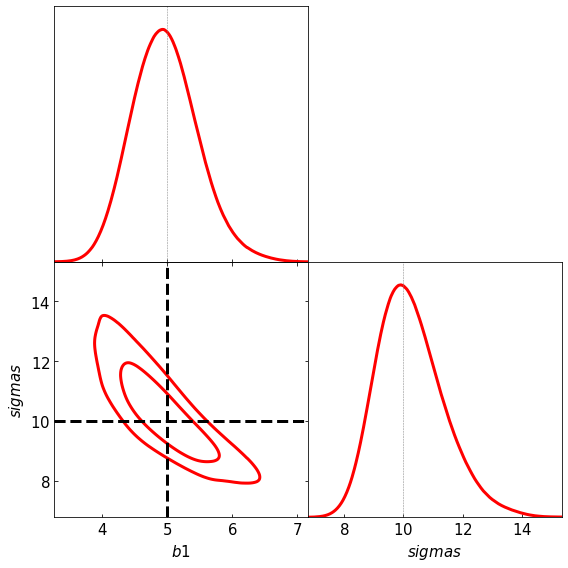

In [13]:
colors = ['blue','red']

g = plots.get_subplot_plotter(width_inch=8)
g.settings.legend_fontsize = 15
g.settings.axes_fontsize = 15
g.settings.progress = True
g.settings.axes_labelsize = 15
g.settings.title_limit = False
g.settings.num_plot_contours = 2
g.triangle_plot([samples_marginalised],
                 line_args = [{'ls':'-','lw':3,'color':colors[1]},
                              {'ls':'-','lw':3,'color':colors[0]}],
                
                 contour_args = [{'ls':'-','lw':3,'color':colors[1]},
                              {'ls':'-','lw':3,'color':colors[0]}],
                 filled=False,markers=[5,10],marker_args={'ls':'--','lw':3,'color':'black'})

We recovered the input parameters! Using the marginalized likelihood only required one iteration of the Gelman-Rubin criteria convergence criteria. Now, let's test without doing the linear marginalization

# Sampling the unmarginalized posterior

In [14]:
#Smooth AMP sampler
handle_NOTMARG = 'NOT_marginalised_smoothAMP'
notMARG_prior = "NOT_marginalised_smoothAMP"
MCMC_NotMargSmoothAMP = MCMC_toolkit.MCMC(1,notMARG_prior)
MCMC_NotMargSmoothAMP.set_walkers(MCMC_NotMargSmoothAMP.ndim*WALKERS_PER_PARAMETER)
flat_prior_NotMargSmoothAMP = MCMC_NotMargSmoothAMP.in_prior

Using  NOT_marginalised_smoothAMP file


In [15]:
#Define the associated log likelihood
def NotMarg_Likelihood(theta, flat_prior, DATA, invCOV, kh, ps_smooth_func):

    #Apply a flat prior to some parameters
    if not(flat_prior(theta)):
        return(-np.inf)
    
    #Get the theory
    THEORY = SmoothAmplitude(theta, args = (kh, ps_smooth_func))
    diff = THEORY - DATA
    
    #Compute chi2
    chi2 = margLIN.QuadraticForm(diff, diff, invCOV)
    
    return -0.5*(chi2)

In [16]:
MCMC_NotMargSmoothAMP.run_MCMC_gelman(gelman_rubins, handle_NOTMARG, NotMarg_Likelihood, new_run=True,
    args=(flat_prior_NotMargSmoothAMP, fake_data, np.linalg.inv(fake_COV), k_array, ps_smooth_func), a=2.0)

You are considering 1000 as the minimum lenght for the chain
Convergence test happens every 1000 steps
Number of walkers: 49
Number of Parameters: 7
Number of parallel chains: 4
*******************************Preparing chain 0********************************
Positions for the chain 0
Using uniform prior


For param B :
Minimum: 1.02 | Maximum: 9.21

For param sigma_s :
Minimum: 0.84 | Maximum: 34.52

For param a1 :
Minimum: -0.1 | Maximum: 0.09

For param a2 :
Minimum: -0.09 | Maximum: 0.1

For param a3 :
Minimum: -0.1 | Maximum: 0.1

For param a4 :
Minimum: -0.1 | Maximum: 0.1

For param a5 :
Minimum: -0.1 | Maximum: 0.1

Go!


100%|██████████| 1000/1000 [00:07<00:00, 142.26it/s]


*******************************Preparing chain 1********************************
Positions for the chain 1
Using uniform prior


For param B :
Minimum: 1.01 | Maximum: 10.0

For param sigma_s :
Minimum: 0.12 | Maximum: 34.5

For param a1 :
Minimum: -0.1 | Maximum: 0.08

For param a2 :
Minimum: -0.1 | Maximum: 0.1

For param a3 :
Minimum: -0.1 | Maximum: 0.1

For param a4 :
Minimum: -0.1 | Maximum: 0.1

For param a5 :
Minimum: -0.1 | Maximum: 0.1

Go!


100%|██████████| 1000/1000 [00:07<00:00, 141.74it/s]


*******************************Preparing chain 2********************************
Positions for the chain 2
Using uniform prior


For param B :
Minimum: 1.08 | Maximum: 9.94

For param sigma_s :
Minimum: 0.77 | Maximum: 33.47

For param a1 :
Minimum: -0.1 | Maximum: 0.1

For param a2 :
Minimum: -0.1 | Maximum: 0.09

For param a3 :
Minimum: -0.09 | Maximum: 0.1

For param a4 :
Minimum: -0.1 | Maximum: 0.1

For param a5 :
Minimum: -0.1 | Maximum: 0.09

Go!


100%|██████████| 1000/1000 [00:06<00:00, 146.58it/s]


*******************************Preparing chain 3********************************
Positions for the chain 3
Using uniform prior


For param B :
Minimum: 1.03 | Maximum: 9.91

For param sigma_s :
Minimum: 0.3 | Maximum: 34.27

For param a1 :
Minimum: -0.1 | Maximum: 0.09

For param a2 :
Minimum: -0.09 | Maximum: 0.09

For param a3 :
Minimum: -0.1 | Maximum: 0.1

For param a4 :
Minimum: -0.1 | Maximum: 0.1

For param a5 :
Minimum: -0.1 | Maximum: 0.1

Go!


100%|██████████| 1000/1000 [00:06<00:00, 159.39it/s]


All chains with the minimum length!
Checking convergence...
Removed 0.5 as burn in
Removed 0.5 as burn in
Removed 0.5 as burn in
Removed 0.5 as burn in
epsilon =  [0.0444049  0.0144312  0.18330694 0.17515507 0.14404528 0.113827
 0.07448238]
Did not converge! Running more steps...
Running iteration 1


100%|██████████| 1000/1000 [00:06<00:00, 162.63it/s]


epsilon =  [0.01419355 0.01569294 0.02709515 0.02779712 0.02456502 0.0206185
 0.01430771]
Removed 0.5 as burn in
Removed 0.5 as burn in
Removed 0.5 as burn in
Removed 0.5 as burn in
Running iteration 2


100%|██████████| 1000/1000 [00:06<00:00, 162.92it/s]


epsilon =  [0.00873869 0.00947495 0.00933226 0.01041191 0.01062083 0.00998301
 0.00875751]
Removed 0.5 as burn in
Removed 0.5 as burn in
Removed 0.5 as burn in
Removed 0.5 as burn in
Running iteration 3


100%|██████████| 1000/1000 [00:06<00:00, 158.71it/s]


epsilon =  [0.00284764 0.00479531 0.0043022  0.00446031 0.00410584 0.00375745
 0.0031669 ]
Removed 0.5 as burn in
Removed 0.5 as burn in
Removed 0.5 as burn in
Removed 0.5 as burn in
Convergence Achieved!
Plotting walkers position over steps...
Plotting the correlation matrix...
Making a corner plot...
Removed no burn in
plotting:  ['B', 'sigma_s']
plotting:  ['B', 'a1']
plotting:  ['B', 'a2']
plotting:  ['B', 'a3']
plotting:  ['B', 'a4']
plotting:  ['B', 'a5']
plotting:  ['sigma_s', 'a1']
plotting:  ['sigma_s', 'a2']
plotting:  ['sigma_s', 'a3']
plotting:  ['sigma_s', 'a4']
plotting:  ['sigma_s', 'a5']
plotting:  ['a1', 'a2']
plotting:  ['a1', 'a3']
plotting:  ['a1', 'a4']
plotting:  ['a1', 'a5']
plotting:  ['a2', 'a3']
plotting:  ['a2', 'a4']
plotting:  ['a2', 'a5']
plotting:  ['a3', 'a4']
plotting:  ['a3', 'a5']
plotting:  ['a4', 'a5']
Done!


In [17]:
chain_NotMarg = MCMC_NotMargSmoothAMP.get_chain(handle = handle_NOTMARG, gelman = gelman_rubins)
samples_NotMarginalised = MCSamples(samples = chain_NotMarg, 
names = ["b1", "sigmas", "a1", "a2", "a3", "a4", "a5"], 
labels = ["b1", "sigmas", "a1", "a2", "a3", "a4", "a5"],
label = "Not marginalized posterior - 3 Gelman-Rubin iterations", settings = settings)

Removed 0.5 as burn in


plotting:  ['b1', 'sigmas']
plotting:  ['b1', 'a1']
plotting:  ['b1', 'a2']
plotting:  ['b1', 'a3']
plotting:  ['b1', 'a4']
plotting:  ['b1', 'a5']
plotting:  ['sigmas', 'a1']
plotting:  ['sigmas', 'a2']
plotting:  ['sigmas', 'a3']
plotting:  ['sigmas', 'a4']
plotting:  ['sigmas', 'a5']
plotting:  ['a1', 'a2']
plotting:  ['a1', 'a3']
plotting:  ['a1', 'a4']
plotting:  ['a1', 'a5']
plotting:  ['a2', 'a3']
plotting:  ['a2', 'a4']
plotting:  ['a2', 'a5']
plotting:  ['a3', 'a4']
plotting:  ['a3', 'a5']
plotting:  ['a4', 'a5']


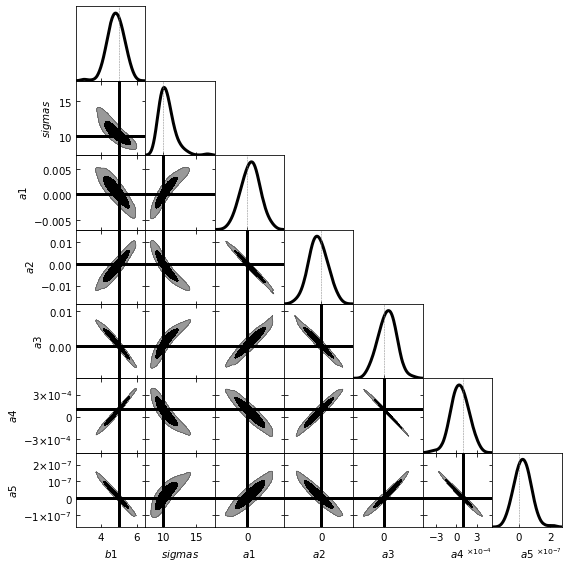

In [19]:
colors = ["black"]

g = plots.get_subplot_plotter(width_inch=8)
g.settings.legend_fontsize = 15
g.settings.axes_fontsize = 15
g.settings.progress = True
g.settings.axes_labelsize = 15
g.settings.title_limit = False
g.settings.num_plot_contours = 2
g.triangle_plot([samples_NotMarginalised],
                 line_args = [{'ls':'-','lw':3,'color':colors[0]}],
                
                 contour_args = [{'ls':'-','lw':3,'color':colors[0]}],
                 filled=True,markers=[5,10, 1e-7,1e-7, 1e-4, 1e-4, 1e-9],
                marker_args={'ls':'-','lw':3,'color':'black'})

We also recovered the input parameters for the non-marginalized case, but it took 3 Gelman-Rubin iterations. Finally, let's compare the posteriors

# Comparing results

plotting:  ['b1', 'sigmas']


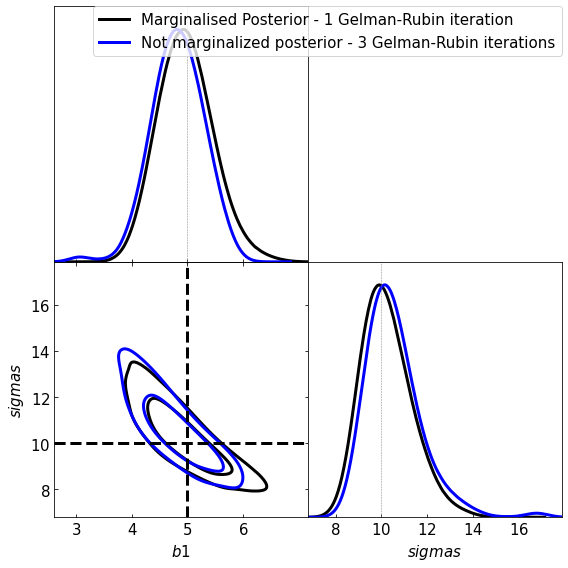

In [20]:
colors = ['blue','black']

g = plots.get_subplot_plotter(width_inch=8)
g.settings.legend_fontsize = 15
g.settings.axes_fontsize = 15
g.settings.progress = True
g.settings.axes_labelsize = 15
g.settings.title_limit = False
g.settings.num_plot_contours = 2
g.triangle_plot([samples_marginalised,samples_NotMarginalised],["b1","sigmas"],
                 line_args = [{'ls':'-','lw':3,'color':colors[1]},
                              {'ls':'-','lw':3,'color':colors[0]}],
                
                 contour_args = [{'ls':'-','lw':3,'color':colors[1]},
                              {'ls':'-','lw':3,'color':colors[0]}],
                 filled=False,markers=[5,10],marker_args={'ls':'--','lw':3,'color':'black'})
g.export("marginalised_vs_nonmarginalised.png")